L'objectif de ce notebook est de créer un outil permettant d'éviter le lancement d'une évaluation en important les informations d'un log de screen.



In [13]:
import re

re_epoch = re.compile(r"Finished epoch \[\d+\] in \[(\d+\.?\d*)\] secs")
re_finish = re.compile(r"Finished training in \[(\d+\.?\d*)\]")
      
model = []                 

def parse_model(file, model):
    with open(file) as f:
        current = None
        testing = False
        for line in f:
            stripped = line.strip()
            if stripped.startswith("modelname: "):
                current = stripped[len("modelname: "):]
                model.append({
                    "tar": "",
                    "epochs": [],
                    "scores": {
                        # "taskname": {
                            # "all/unknown/ambiguous": {"precision": 0., "accuracy": 0, etc.} 
                        # }
                    }
                })
                continue
            # If we do not have a current model
            if not current:
                continue
            # Get the model tar exported
            if stripped.startswith("Saved best model to: ["):
                model[-1]["tar"] = stripped[len("Saved best model to: ["):-1]
                continue
            # Get the time of each epoch
            epoch = re_epoch.findall(stripped)
            if epoch:
                model[-1]["epochs"].append(float(epoch[0]))
                continue
            # Get the finished time
            finished = re_finish.findall(stripped)
            if finished:
                model[-1]["time"] = float(finished[0])
            if "Bye!" == stripped:
                current = None
                testing = False

            # Parsing test results

            if stripped == "Evaluating model on test set":
                testing = True
                current_category = ""
                headers = []
                continue
            if testing:
                # If the line starts with "## ", we are testing a category
                if stripped.startswith("## "):
                    current_category = stripped[len("## "):]
                    model[-1]["scores"][current_category] = {}
                    headers = []
                    continue
                # On the contrary, if it starts with "|" we are in a table
                if stripped.startswith("|") and current_category:
                    # We split around "|" and remove the first and last value, which are empty values
                    real_rows = [val.strip() for val in stripped.split("|")[1:-1]]
                    if re.match("-+", real_rows[0]):
                        continue
                    if not headers:
                        headers = real_rows[1:]
                        continue
                    model[-1]["scores"][current_category][real_rows[0]] = dict(zip(headers, real_rows[1:]))
    return model

model = parse_model("/home/thibault/SynologyDrive/Thèse/Modeles/Logs/model-percent-final.log", model)
model = parse_model("/home/thibault/SynologyDrive/Thèse/Modeles/Logs/model-percent-0.05.log", model)
        
                

In [14]:
# Transformation en dictionnaire
import re
_re_percent = re.compile(r"(0,\d+)")

models = {}
def clean_model_name(model_tar):
    return _re_percent.findall(model_tar)[0].replace(",", ".")


def cnn_layers(model_tar):
    return str(int("simpler" not in model_tar) + 1)

for m in sorted(model, key=lambda x: x["tar"]):
    if not m["tar"]:
        continue
    name, layers = clean_model_name(m["tar"]), cnn_layers(m["tar"])
    if name not in models:
        models[name] = {}
    models[name][layers] = m
        

In [15]:
tasks = list(model[0]["scores"].keys())
# We iterate over tasks and do not use set(list()) to keep the original order of the different categories
categories = []
for task in tasks:
    for cat in model[0]["scores"][task]:
        if cat not in categories:
            categories.append(cat)
metrics = list(model[0]["scores"][tasks[0]][categories[0]].keys())

print("Tasks", tasks)
print("Categories", categories)
print("Metrics", metrics)

Tasks ['lemma', 'pos', 'Gend']
Categories ['all', 'unknown-tokens', 'ambiguous-tokens', 'unknown-targets']
Metrics ['accuracy', 'precision', 'recall', 'support']


In [16]:
combinator = [(task, layer, cat, metric) for task in tasks for cat in categories for metric in ["accuracy", "precision", "support"] for layer in ["1", "2"]]
header = ["Model"] + [task+"_"+"({l} Layers) {cat} / {metric}".format(l=layer, cat=" ".join(cat.split("-")).capitalize(), metric=metric.capitalize()) for (task, layer, cat, metric) in combinator]

rows = [header]
for model_name, model_layers in models.items():
    rows.append([model_name])
    for (task, layer, cat, metric) in combinator:
        if cat in model_layers[layer]["scores"][task]:
            rows[-1].append(model_layers[layer]["scores"][task][cat][metric])
        else:
            rows[-1].append("NaN")

## Export des résultats de parsage

In [17]:
import csv


with open("out-percent.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(rows)

## Filtrage manuel

1. Liste des champs
2. Choix des champs (Hard Codé)
3. Création fichier

In [18]:
# 1
import csv
with open("out-percent.csv") as f:
    reader = csv.DictReader(f)
    for field in reader.fieldnames:
        print('"'+field+'",')

"Model",
"lemma_(1 Layers) All / Accuracy",
"lemma_(2 Layers) All / Accuracy",
"lemma_(1 Layers) All / Precision",
"lemma_(2 Layers) All / Precision",
"lemma_(1 Layers) All / Support",
"lemma_(2 Layers) All / Support",
"lemma_(1 Layers) Unknown tokens / Accuracy",
"lemma_(2 Layers) Unknown tokens / Accuracy",
"lemma_(1 Layers) Unknown tokens / Precision",
"lemma_(2 Layers) Unknown tokens / Precision",
"lemma_(1 Layers) Unknown tokens / Support",
"lemma_(2 Layers) Unknown tokens / Support",
"lemma_(1 Layers) Ambiguous tokens / Accuracy",
"lemma_(2 Layers) Ambiguous tokens / Accuracy",
"lemma_(1 Layers) Ambiguous tokens / Precision",
"lemma_(2 Layers) Ambiguous tokens / Precision",
"lemma_(1 Layers) Ambiguous tokens / Support",
"lemma_(2 Layers) Ambiguous tokens / Support",
"lemma_(1 Layers) Unknown targets / Accuracy",
"lemma_(2 Layers) Unknown targets / Accuracy",
"lemma_(1 Layers) Unknown targets / Precision",
"lemma_(2 Layers) Unknown targets / Precision",
"lemma_(1 Layers) Unknown t

In [19]:
# Etape 2 : choix manuel
kept = [
"Model",
    "lemma_(1 Layers) All / Accuracy",
    "lemma_(2 Layers) All / Accuracy",
    "lemma_(1 Layers) All / Precision",
    "lemma_(2 Layers) All / Precision",
    "lemma_(1 Layers) Unknown tokens / Accuracy",
    "lemma_(2 Layers) Unknown tokens / Accuracy",
    "lemma_(1 Layers) Unknown tokens / Precision",
    "lemma_(2 Layers) Unknown tokens / Precision",
    #"lemma_(1 Layers) Unknown tokens / Support",
    "pos_(1 Layers) All / Accuracy",
    "pos_(2 Layers) All / Accuracy",
    "pos_(1 Layers) All / Precision",
    "pos_(2 Layers) All / Precision",
    "pos_(1 Layers) Unknown tokens / Accuracy",
    "pos_(2 Layers) Unknown tokens / Accuracy",
    "pos_(1 Layers) Unknown tokens / Precision",
    "pos_(2 Layers) Unknown tokens / Precision",
    #"pos_(1 Layers) Unknown tokens / Support",
    "Gend_(1 Layers) All / Accuracy",
    "Gend_(2 Layers) All / Accuracy",
    "Gend_(1 Layers) All / Precision",
    "Gend_(2 Layers) All / Precision",
    "Gend_(1 Layers) Unknown tokens / Accuracy",
    "Gend_(2 Layers) Unknown tokens / Accuracy",
    "Gend_(1 Layers) Unknown tokens / Precision",
    "Gend_(2 Layers) Unknown tokens / Precision",
    #"Gend_(1 Layers) Unknown tokens / Support",
]

In [20]:
import csv
with open("percent-man.csv", "w") as f:
    writer = csv.DictWriter(f, fieldnames=kept)
    writer.writeheader()
    # Need to rename fields
    with open("out-percent.csv") as f:
        reader = csv.DictReader(f)
        for row in reader:
            writer.writerow({field: row[field] for field in kept})

In [21]:
# Couleurs
print({field.split("_")[1]: "" for field in kept if "_" in field})

colors = {
    '(1 Layers) All / Accuracy': 'gray',
    '(2 Layers) All / Accuracy': 'silver',
    '(1 Layers) All / Precision': 'coral',
    '(2 Layers) All / Precision': 'peachpuff',
    '(1 Layers) Unknown tokens / Accuracy': 'darkgreen',
    '(2 Layers) Unknown tokens / Accuracy': 'palegreen',
    '(1 Layers) Unknown tokens / Precision': 'darkgoldenrod',
    '(2 Layers) Unknown tokens / Precision': 'gold',
    '(1 Layers) Unknown tokens / Support': 'darkred'
}


{'(1 Layers) All / Accuracy': '', '(2 Layers) All / Accuracy': '', '(1 Layers) All / Precision': '', '(2 Layers) All / Precision': '', '(1 Layers) Unknown tokens / Accuracy': '', '(2 Layers) Unknown tokens / Accuracy': '', '(1 Layers) Unknown tokens / Precision': '', '(2 Layers) Unknown tokens / Precision': ''}


/home/thibault/dev/these/these_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  # This is added back by InteractiveShellApp.init_path()


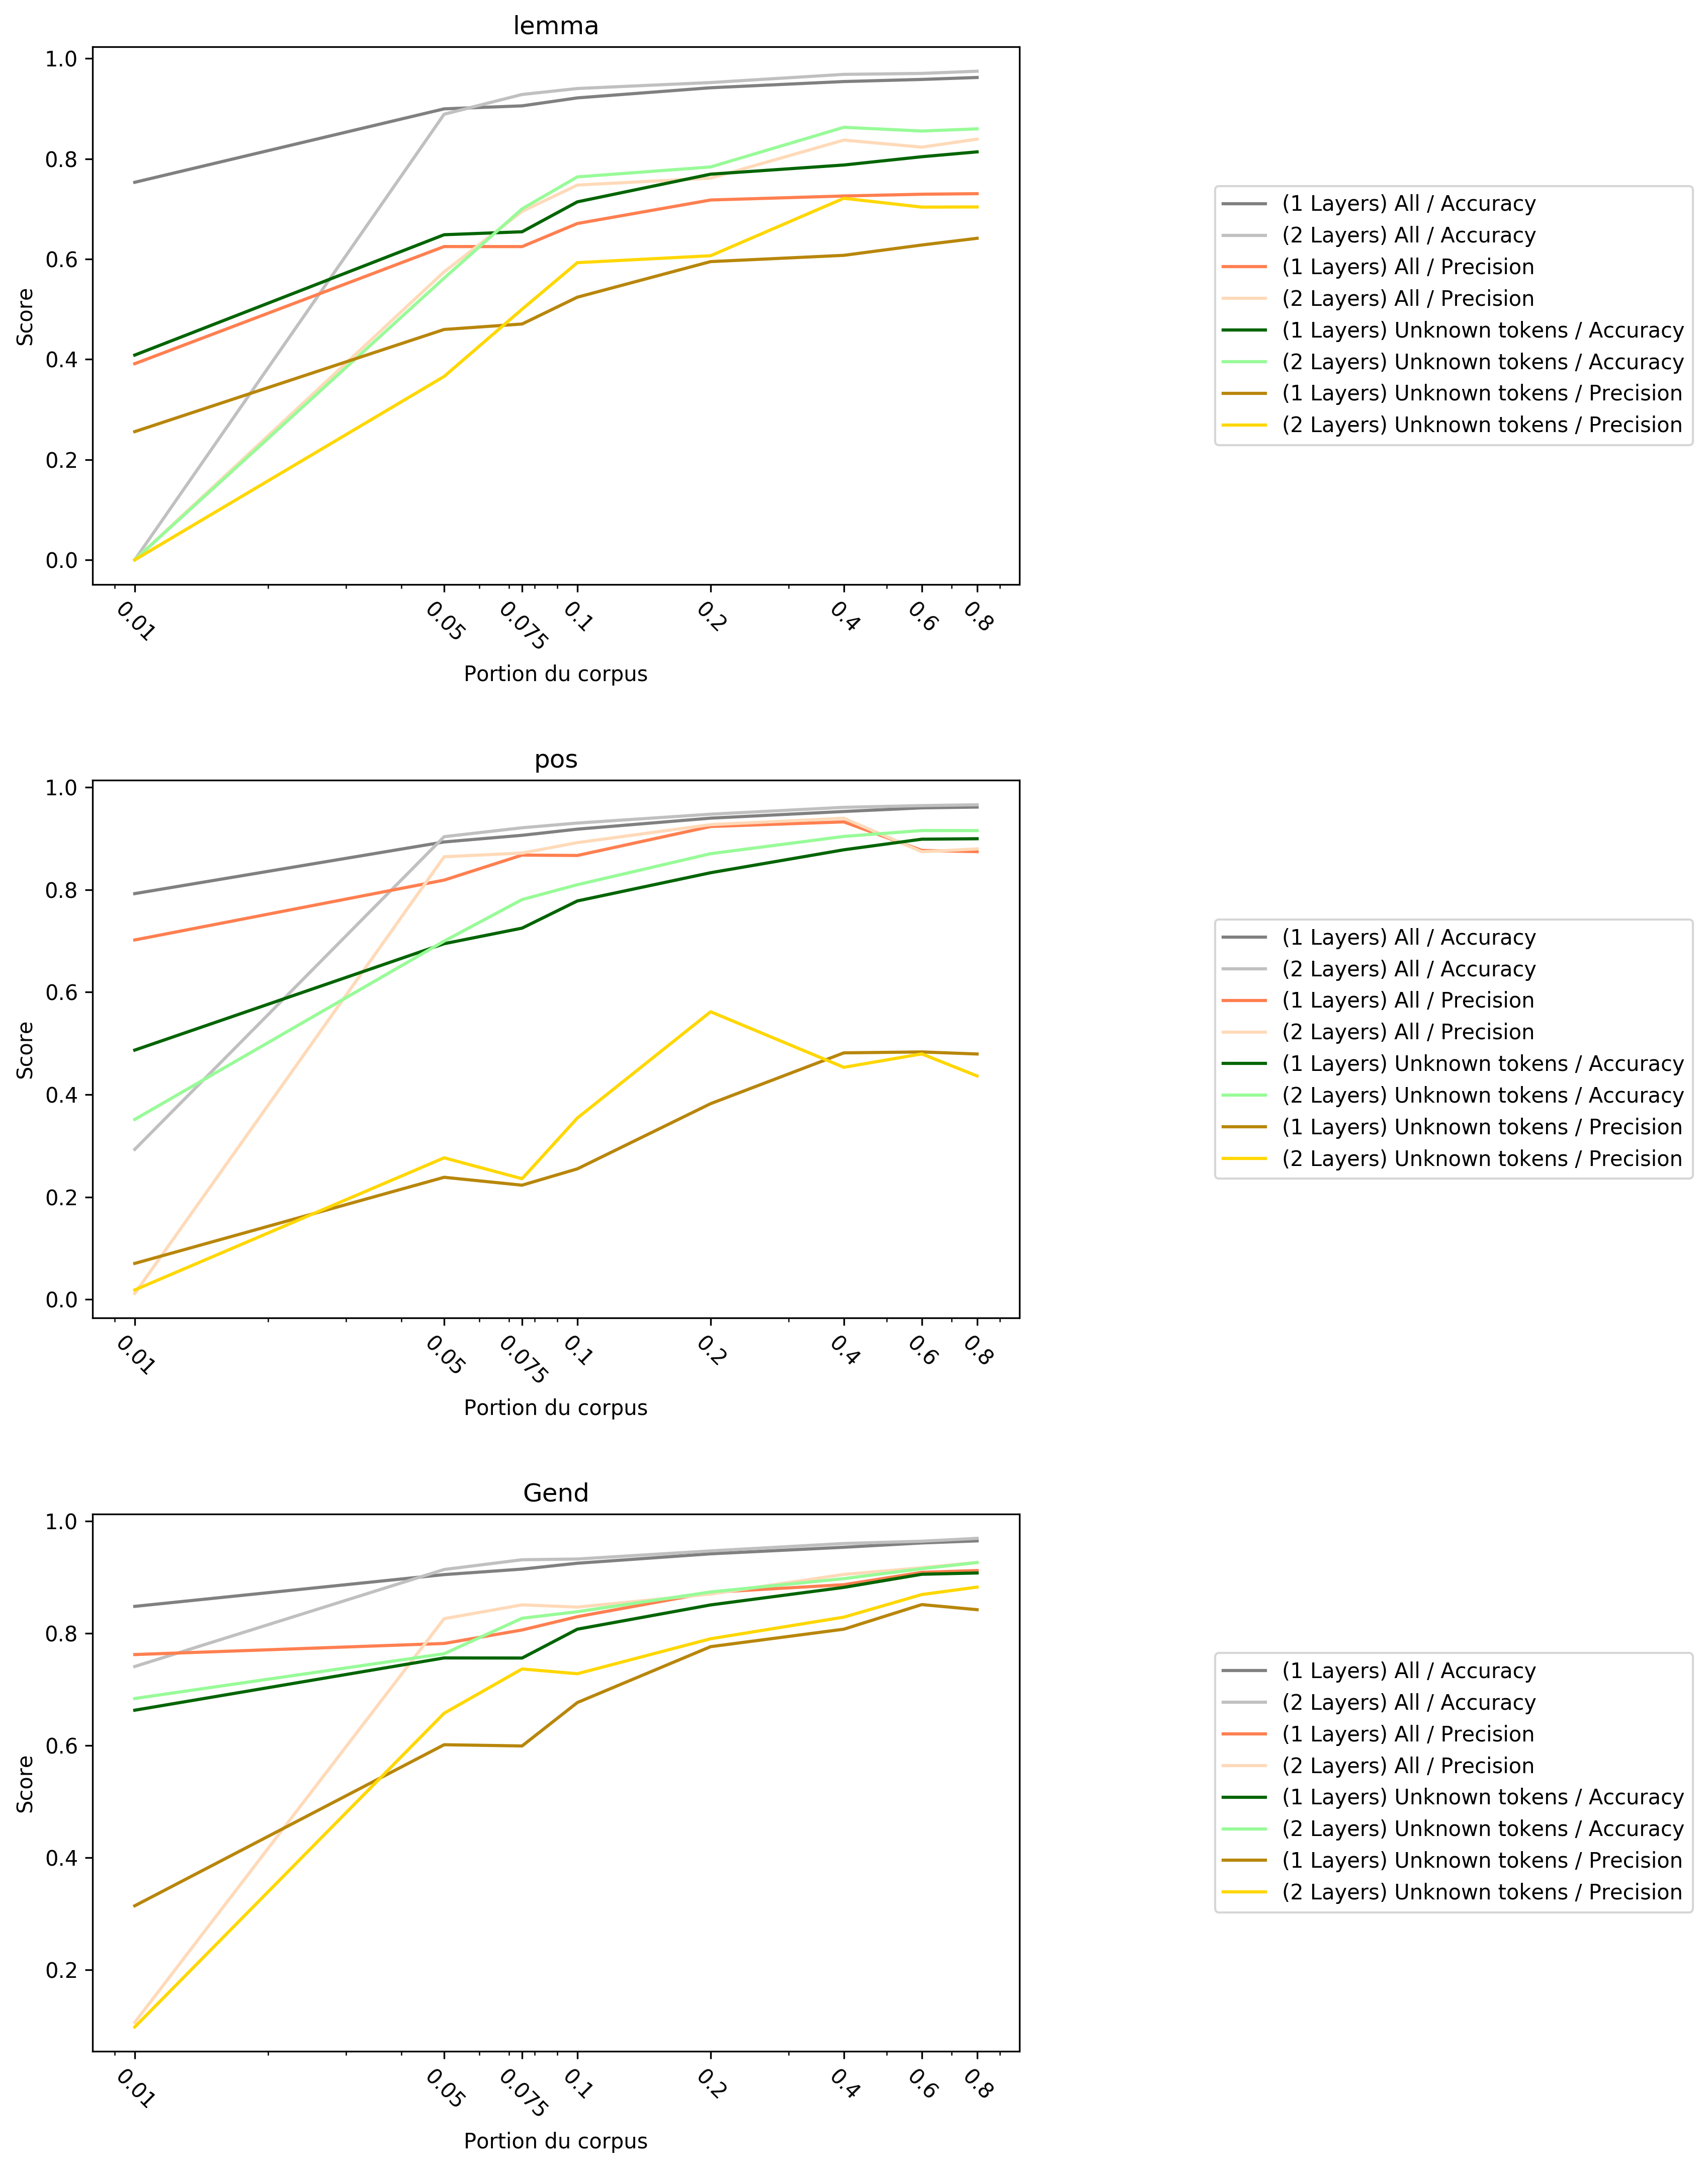

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

fig, axes = plt.subplots(nrows=3)
fig.set_size_inches(7.5, 15, forward=True)
fig.set_dpi(300)
fig.patch.set_facecolor('xkcd:white')


df = pd.DataFrame.from_csv("percent-man.csv")
df = df.reset_index()
df = df.rename(columns={"Model":"Portion du corpus"})
ax = None

def filter_columns(column_name) -> bool:
    if "Support" in column_name and "All" in column_name:
        return True
    return False

drawn_cats = []
legends = []
indexes = [float(index) for index in list(df["Portion du corpus"])]
ticks = [str(index) for index in indexes]

for column in df.columns:
    if column == "Portion du corpus":
        continue
    secondary_y = "Support" in column
    _cat = column.split("_")[0]
    if _cat not in drawn_cats:
        drawn_cats.append(_cat)
        legends.append([])
    
    ax = axes[drawn_cats.index(_cat)]
    ax.set_xticks(indexes, ticks)
    ax.set_xticklabels(ticks)
    ax.set_title(_cat)
    
    # We skip all information
    if filter_columns(column):
        continue
        
    legends[-1].append(column.split("_")[1])
    df.plot(
        x="Portion du corpus",
        y=[column],
        secondary_y=secondary_y,
        ax=ax,
        xticks=df["Portion du corpus"],
        logx=True,
        color=colors[legends[-1][-1]]
    )
    ax.set_xticklabels(df["Portion du corpus"])

for legend, ax in zip(legends, axes):
    box = ax.get_position()
    # Do twice because we got two y axes
    if hasattr(ax, "right_ax"):  # In case we keep support
        ax.set_position(
            [box.x0, box.y0, box.width * 0.5, box.height],
            [box.x0, box.y0, box.width * 0.5, box.height]
        )
        # Put a legend to the right of the current axis
        lines = ax.get_lines() + ax.right_ax.get_lines()
        ax.legend(lines, legend, loc='center left', bbox_to_anchor=(1.2, 0.5), ncol=1)

        ax.set_ylabel("Score")
        ax.right_ax.set_ylabel("Tokens")
    else:
        ax.set_position(
            [box.x0, box.y0, box.width, box.height]
        )
        lines = ax.get_lines()
        ax.legend(lines, legend, loc='center left', bbox_to_anchor=(1.2, 0.5), ncol=1)
        ax.set_ylabel("Score")

for ax in plt.gcf().axes:
    ax.set_xticklabels(ticks, rotation=-45)
    
fig.tight_layout(pad=3.0)